# K-Means Clustering

Tomado y adaptado de [Pluralsight](https://www.pluralsight.com/courses/building-clustering-models-scikit-learn)

El dataset que se va a utilizar contiene cuatro características (longitud y ancho de sépalos y pétalos) de 50 muestras de tres especies de flores Iris (Iris setosa, Iris virginica e Iris versicolor).

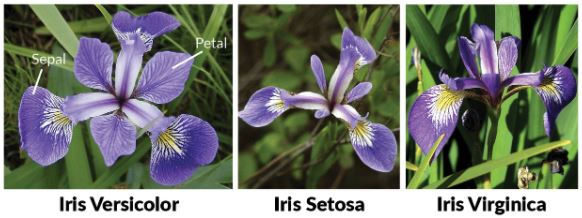

Importamos librerías necesarias.

In [ ]:
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sb
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import pairwise_distances_argmin_min

%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
plt.rcParams['figure.figsize'] = (25, 12)
plt.style.use('ggplot')

## 1. Exploración de los datos

Cargamos el dataset

In [ ]:
#Para abrir desde colab
from google.colab import files
import io

uploaded = files.upload()
iris_df = pd.read_csv(io.BytesIO(uploaded["Taller5_iris.csv"]))

#Para abrir desde un IDE de escritorio
#iris_df=pd.read_csv('Taller5_iris.csv')
#iris_df.head()

Saving Taller5_iris.csv to Taller5_iris.csv


In [ ]:
iris_df.tail()

,sepal-length,sepal-width,petal-length,petal-width,class
145,6.7,3.0,5.2,2.3,Iris-virginica
146,6.3,2.5,5.0,1.9,Iris-virginica
147,6.5,3.0,5.2,2.0,Iris-virginica
148,6.2,3.4,5.4,2.3,Iris-virginica
149,5.9,3.0,5.1,1.8,Iris-virginica


con el atributo `.shape` vemos que el conjunto de datos está compuesto por 150 registros correspondientes a 150 flores particulares con sus respectivas medidas.

Cada registro tiene 5 columnas, las 4 características y la correspondiente a la clase (especie). Normalmente para este tipo de problemas no disponemos de las etiquetas y por eso se usa una tecnica a aprendizaje no supervisado como lo es el clustering.

In [ ]:
iris_df.shape

(150, 5)

Si invocamos la funcion `.unique()` en una columna particular obtendremos las etiquetas únicas presentes en el conjunto de datos.

In [ ]:
iris_df['class'].unique()

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

Contando la cantidad de datos en cada clase vemos que los datos estan perfectamente balanceados, con la misma cantidad de observaciones para cada especie, haciendo que este conjunto de datos (incluyendo las etiquetas) sea un candidato perfecto para trabajar con árboles de clasificación.

In [ ]:
print(iris_df.groupby('class').size())

class
Iris-setosa        50
Iris-versicolor    50
Iris-virginica     50
dtype: int64


Ahora vamos a visualizar las 4 características y la especie en un único grafico 3D.

* sepal length en el eje x
* petal length en el eje y
* petal width en el eje z
* especie con diferentes colores
* el tamaño de los puntos es proporcional a sepal width

En este gráfico se puede hacer zoom y también se puede rotar usando el mouse.

Teniendo en cuenta que esta técnica solo sirve para datos numéricos, debemos convertir los valores categóricos como las cadenas de caracteres en números. Esto lo podemos hacer usando `LabelEncoder()` de scikit learn; así se asignarán etiquetas numéricas a cada especie (empezando desde cero).

In [ ]:
label_encoding = preprocessing.LabelEncoder()
iris_df['class'] = label_encoding.fit_transform(iris_df['class'].astype(str))
iris_df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [ ]:
iris_df.tail()

,sepal-length,sepal-width,petal-length,petal-width,class
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2
149,5.9,3.0,5.1,1.8,2


Se ha hecho la siguiente asignación de etiquetas:

0: Setosa

1: Versicolor

2: Virginica

Se puede observar que las muestras están ordenadas por especie. A continuación, vamos a mezclarlas para visualizar mejor el contenido generando nuevos indices.

In [ ]:
iris_df = iris_df.sample(frac=1).reset_index(drop=True)
iris_df.head()

,sepal-length,sepal-width,petal-length,petal-width,class
0,5.7,3.8,1.7,0.3,0
1,5.8,2.7,5.1,1.9,2
2,5.0,2.0,3.5,1.0,1
3,5.5,3.5,1.3,0.2,0
4,5.1,3.8,1.9,0.4,0


Por último podemos hacer un resumen estadístico de los datos antes de continuar con la visualización. Excluimos las clases porque son valores categóricos y no tiene mucho sentido en este caso aplicarle esta operación.

In [ ]:
iris_df.describe().drop('class', axis=1)

,sepal-length,sepal-width,petal-length,petal-width
count,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.054000,3.758667,1.198667
std,0.828066,0.433594,1.764420,0.763161
min,4.300000,2.000000,1.000000,0.100000
25%,5.100000,2.800000,1.600000,0.300000
50%,5.800000,3.000000,4.350000,1.300000
75%,6.400000,3.300000,5.100000,1.800000
max,7.900000,4.400000,6.900000,2.500000


### Visualizando los datos

In [ ]:
iris_features = iris_df.drop('class', axis=1)
iris_features.head()

,sepal-length,sepal-width,petal-length,petal-width
0,5.7,3.8,1.7,0.3
1,5.8,2.7,5.1,1.9
2,5.0,2.0,3.5,1.0
3,5.5,3.5,1.3,0.2
4,5.1,3.8,1.9,0.4


Ajustamos un nuevo modelo usando las cuatro caracteristicas.

In [ ]:
kmeans_model = KMeans(n_clusters=3).fit(iris_features)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning:

The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning



### Predicción para nueva observación

Suponiendo que encontramos una nueva flor (independiente de los datos que teniamos) con las siguientes características:

sepal-length = 6.22,  sepal-width = 4.3,  petal-length = 1.4, petal-width = 0.4.


Nos gustaría saber dentro de cuál grupo se podria clasificar.

In [138]:
# Con el modelo entrenado puedo hacer predicciones para
# observaciones nuevas
X_new = np.array([[6.22,4.3,1.4,0.4]]) #nueva observación

new_labels = kmeans_model.predict(X_new)
print(new_labels)

[1]


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names



In [144]:
# Con el modelo entrenado puedo hacer predicciones para
# observaciones nuevas


labels = np.array([ 'Iris-virginica','Iris-setosa', 'Iris-versicolor'])
X_new = np.array([[6.7,3,5.2,2.3]]) #nueva observación

new_labels = kmeans_model.predict(X_new)
print(new_labels)

# Obtener la clase predominante para el cluster al que pertenece la nueva observación
predicted_class = labels[new_labels]

print(f"La nueva observación {X_new[0]} pertenece al cluster {new_labels} y se clasifica como '{predicted_class}'")

[0]
La nueva observación [6.7 3.  5.2 2.3] pertenece al cluster [0] y se clasifica como '['Iris-virginica']'


/usr/local/lib/python3.10/dist-packages/sklearn/base.py:465: UserWarning:

X does not have valid feature names, but KMeans was fitted with feature names

